In [1]:
import os
os.chdir('..')
!pwd
import bilevel
from bilevel.build_all_models import *
from bilevel.OnlineLinearExpert import *
from bilevel.OnlineTreeExpert import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/Users/krishna/Documents/Research/Simultaneous Classifier/folktables-experiments/multidecomp


In [2]:
df_medical = pd.read_csv('./data_small/insurance.csv')

In [15]:
df_medical.isnull().any(axis=1), df_medical.isnull().sum()

(0       False
 1       False
 2       False
 3       False
 4       False
         ...  
 1333    False
 1334    False
 1335    False
 1336    False
 1337    False
 Length: 1338, dtype: bool,
 age         0
 sex         0
 bmi         0
 children    0
 smoker      0
 region      0
 charges     0
 dtype: int64)

In [8]:
df_medical.head()
# age, bmi, #children, charges - numeric
# sex, smoker, region

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [27]:
print(df_medical['sex'].unique(),  df_medical['smoker'].unique(), df_medical['region'].unique(), df_medical['children'].unique())
print(df_medical.describe())

['female' 'male'] ['yes' 'no'] ['southwest' 'southeast' 'northwest' 'northeast'] [0 1 3 2 5 4]
               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max      64.000000    53.130000     5.000000  63770.428010


In [7]:
df_medical[df_medical['sex'] == 'male']['charges'].mean(), df_medical[df_medical['sex'] == 'female']['charges'].mean()


(13956.751177721893, 12569.578843835347)

In [10]:
df_medical[df_medical['smoker'] == 'yes']['charges'].mean(), df_medical[df_medical['smoker'] == 'no']['charges'].mean()

(32050.23183153284, 8434.268297856204)

In [13]:
df_medical['smoker'].value_counts()

smoker
no     1064
yes     274
Name: count, dtype: int64

In [26]:
df_medical[df_medical['children'] == 0]['charges'].mean(), df_medical[df_medical['children'] == 1]['charges'].mean()

(12365.97560163589, 12731.171831635802)

In [31]:
df_medical[df_medical['bmi'] > 25]['charges'].mean(), df_medical[df_medical['bmi'] < 25]['charges'].mean()

(13946.476035324473, 10282.224474367347)

In [32]:
numeric_all = ['age', 'bmi', 'children', 'charges']
cat_all = ['sex', 'smoker', 'region']
df_medical_mm = numeric_scaler(df_medical, numeric_all)
df_medical_mm_oh = one_hot(df_medical_mm, cat_all)
df_medical_mm_oh.drop(cat_all, axis = 1, inplace=True) # drop the categorics that were used to one hot encode
df_medical_mm_oh = df_medical_mm_oh * 1.0 # make bool true, false into 1.0, 0.0
df_medical_mm_oh.head()

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,0.021739,0.321227,0.0,0.251611,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.000000,0.479150,0.2,0.009636,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.217391,0.458434,0.6,0.053115,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.326087,0.181464,0.0,0.333010,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.304348,0.347592,0.0,0.043816,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0


In [33]:
X_dat = df_medical_mm_oh.drop('charges', axis=1)
y_dat = df_medical_mm_oh['charges']

from sklearn.linear_model import LinearRegression, Ridge
lr = LinearRegression()
lr.fit(X_dat, y_dat)
lr.score(X_dat, y_dat)

0.7476531626984347

In [39]:
 from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor(max_depth= 2)
dtr.fit(X_dat, y_dat)
dtr.score(X_dat, y_dat)

0.827363054973973

In [41]:
X_dat.head()

,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,0.021739,0.321227,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.000000,0.479150,0.2,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.217391,0.458434,0.6,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.326087,0.181464,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.304348,0.347592,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0


In [45]:
filter_group = ['sex_male', 'sex_female', 'smoker_no', 'smoker_yes']

In [46]:
# tranining on data for only each group
from sklearn.model_selection import train_test_split
random_seed = 21
X_train, X_test, y_train, y_test = train_test_split(X_dat, 
                                                    y_dat, test_size = 0.2,
                                                    shuffle=True, random_state= random_seed)

models_lr_dict = {}
group_sizes = {}

for g in filter_group:
    indices = (X_train[g] == 1)
    model_lr = LinearRegression()
    model_lr.fit(X_train[indices], y_train[indices])
    key = g
    group_sizes[key] = indices.sum() #sum of all the trues
    models_lr_dict[key] = model_lr

In [47]:
for g in filter_group:
    indices = (X_test[g] == 1)
    key = g
    r2_score_lr = models_lr_dict[key].score(X_test[indices], y_test[indices])
    print(f" {key}, test group size {group_sizes[key]}  r2 score for least squares is {r2_score_lr:.4f}")

 sex_male, test group size 545  r2 score for least squares is 0.7740
 sex_female, test group size 525  r2 score for least squares is 0.6788
 smoker_no, test group size 855  r2 score for least squares is 0.3335
 smoker_yes, test group size 215  r2 score for least squares is 0.7120


In [49]:
def cross_test_models(model_dict: dict):
    '''
        model_dict: maps keys to linear model, these linear models are already trained and have weights
        sex_cats: labels for the different sexes
        race_cats: labels for the different races
        This function computes the performance of one model on another models data

        With an example, model_dict['SEX_1'] has the linear model trained only of those points which have SEX == 1
        we will test its performance on all the other groups data.
    '''
    keys = list(model_dict.keys())
    l = len(keys)
    mat_2d = np.zeros((l, l))
    for i in range(l):
        model_i = model_dict[keys[i]]
        for j in range(l):
            key = keys[j]
            indices_j = (X_test[key] == 1)
            mat_2d[i, j] = model_i.score(X_test[indices_j], y_test[indices_j]) # how model i performs on test data meant for model j, R2 score
    return mat_2d, keys

In [50]:
import numpy as np
crossmat, keys = cross_test_models(models_lr_dict)
print(crossmat, keys)

[[  0.77395713   0.67423761   0.2718629    0.34950263]
 [  0.77813946   0.67880169   0.25524712   0.39194409]
 [ -0.20102872  -0.14835755   0.33352264  -4.64742037]
 [ -2.0494803   -3.80947698 -17.23561065   0.71200909]] ['sex_male', 'sex_female', 'smoker_no', 'smoker_yes']


<Axes: >

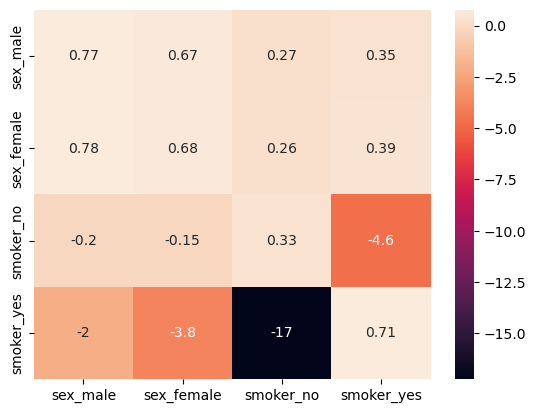

In [51]:
import seaborn as sns # for data visualization
sns.heatmap(crossmat, annot=True, xticklabels=keys, yticklabels=keys)

In [63]:
A_t_ss = pd.concat([df_medical['sex'] == 'male', df_medical['sex'] == 'female', 
                    df_medical['smoker'] == 'yes', df_medical['smoker']=='no'],
                    axis = 1).to_numpy()

A_t_ss = np.hstack((A_t_ss, np.ones((A_t_ss.shape[0],1)))) # adding the always on

In [65]:
np.all(A_t_ss.sum(axis = 1) == 3), np.sum(A_t_ss, axis = 0)

(True, array([ 676.,  662.,  274., 1064., 1338.]))

In [66]:
X_dat.head(), y_dat.head()

(        age       bmi  children  sex_female  sex_male  smoker_no  smoker_yes  \
 0  0.021739  0.321227       0.0         1.0       0.0        0.0         1.0   
 1  0.000000  0.479150       0.2         0.0       1.0        1.0         0.0   
 2  0.217391  0.458434       0.6         0.0       1.0        1.0         0.0   
 3  0.326087  0.181464       0.0         0.0       1.0        1.0         0.0   
 4  0.304348  0.347592       0.0         0.0       1.0        1.0         0.0   
 
    region_northeast  region_northwest  region_southeast  region_southwest  
 0               0.0               0.0               0.0               1.0  
 1               0.0               0.0               1.0               0.0  
 2               0.0               0.0               1.0               0.0  
 3               0.0               1.0               0.0               0.0  
 4               0.0               1.0               0.0               0.0  ,
 0    0.251611
 1    0.009636
 2    0.053115
 3  

In [67]:
# Based on education some college v/s only till high school
# Sex group
# X_dat = df_medical_mm_oh.drop('charges', axis=1)
# y_dat = df_medical_mm_oh['charges']

dirname = './models_adult/baseline/'
# filename = 'ls_medical_ss'
filename = 'ridge_medical_ss'

# expridge = OnlineLinearExpert(X_dat, y_dat, l2_pen = 0.0)
expridge = OnlineLinearExpert(X_dat, y_dat, l2_pen = 1.0)
b_ridgebase = build_baseline_alwayson(dirname, filename, A_t_ss, expridge)

dirname = './models_adult/Anh/'

experts = [OnlineLinearExpert(X_dat, y_dat, l2_pen = 0.0) for _ in range(A_t_ss.shape[1])]
b_Anh = build_Anh(dirname, filename, A_t_ss, experts)

100%|██████████| 1338/1338 [00:08<00:00, 153.07it/s]


In [68]:
# with ls experts
cumloss_groupwise_ada = b_Anh.Anh.cumloss_groupwise_ada
cumloss_base = b_ridgebase.expert.cumloss_groupwise
count_ada_better = 0
for g_ind in range(A_t_ss.shape[1]):
    base = cumloss_base[g_ind][-1]
    ada = cumloss_groupwise_ada[g_ind][-1]
    if base >= ada:
        count_ada_better += 1
    print(g_ind, base, ada , base >= ada)
print(count_ada_better)

0 9.340432693981805 9.056613923934176 True
1 7.870279204337945 7.775014640401702 True
2 9.819313779250635 9.599300260487292 True
3 7.391398119069116 7.232328303848592 True
4 17.210711898319786 16.831628564335887 True
5


In [ ]:
# with ls experts
cumloss_groupwise_ada = b_Anh.Anh.cumloss_groupwise_ada
cumloss_base = b_ridgebase.expert.cumloss_groupwise
count_ada_better = 0
for g_ind in range(A_t_ss.shape[1]):
    base = cumloss_base[g_ind][-1]
    ada = cumloss_groupwise_ada[g_ind][-1]
    if base >= ada:
        count_ada_better += 1
    print(g_ind, base, ada , base >= ada)
print(count_ada_better)